In [13]:
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#load dataset, Time(UTC),prs(m),rad(m)
df = pd.read_csv('data2y.csv',sep=',', header=0, index_col=0, squeeze=True, parse_dates=True)
#non-null object to float64
df['prs(m)'] = pd.to_numeric(df['prs(m)'], errors='coerce')
#prs(m) looks more stable
df.drop(df.columns[[1]], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1036988 entries, 2016-12-31 00:00:52 to 2018-12-30 23:59:19
Data columns (total 1 columns):
prs(m)    1036833 non-null float64
dtypes: float64(1)
memory usage: 15.8 MB


In [3]:
df = df.interpolate()

In [4]:
# one week for prediction work
unknown = 60*24*7
r = df[:-unknown]
p = df[-unknown:]

In [5]:
r.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1026908 entries, 2016-12-31 00:00:52 to 2018-12-23 05:52:17
Data columns (total 1 columns):
prs(m)    1026908 non-null float64
dtypes: float64(1)
memory usage: 15.7 MB


In [6]:
p.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10080 entries, 2018-12-23 05:53:17 to 2018-12-30 23:59:19
Data columns (total 1 columns):
prs(m)    10080 non-null float64
dtypes: float64(1)
memory usage: 157.5 KB


In [29]:
serie= r['prs(m)']
serie = serie - numpy.mean(p.values)

dt = 1/60

stime = r.index[0]
lat = -33.02730833


# TTIDE

In [27]:
import ttide
print(ttide.__version__)

0.3lfk


In [30]:
out = ttide.t_tide(serie, dt, stime, lat)

C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_tide.py:345: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(lhs, rhs)[0].T
C:\Users\sergi\Anaconda3\lib\site-packages\numpy\lib\type_check.py:161: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  return val.real
C:\Users\sergi\Anaconda3\lib\site-packages\numpy\lib\type_check.py:204: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  return val.imag


-----------------------------------
nobs = 1026908 
ngood = 1026907 
record length (days) = 713.13
start time: 2016-12-31 00:00:52
rayleigh criterion = 1.0

Greenwich phase computed with nodal
                   corrections applied to amplitude
                   and phase relative to center time

x0= 0.0334  xtrend= 0
var(data)= 0.14    var(prediction)= 0.02    var(residual)= 0.12
var(prediction)/var(data) (%) = 16.6

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0461     0.013    246.15     36.65        12
* SSA   0.0002282     0.0505     0.018    199.34     28.22       7.7
  MSM   0.0013098     0.0035     0.017    344.10    117.76     0.039
  MM    0.0015122     0.0104     0.015    235.42     79.65      0.49
  MSF   0.0028219     0.0018     0.016    306.89    205.17     0.013
  MF    0.0030501     0.0029     0.016    128.50    181.82     0.031
  ALP1  0.0343966     0.0009     0.016  

C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_utils.py:447: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  x = np.var(out['xingd'].real, ddof=1)
C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_utils.py:449: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  xr = np.var(out['xresgd'].real, ddof=1)


In [11]:
out.keys()

dict_keys(['nobs', 'ngood', 'dt', 'xin', 'xout', 'xres', 'xingd', 'xoutgd', 'xresgd', 'isComplex', 'ray', 'nodcor', 'z0', 'dz0', 'fu', 'nameu', 'tidecon', 'snr', 'synth', 'lat', 'ltype', 'stime'])

In [22]:
from datetime import datetime
from matplotlib.dates import date2num

#getting te timestamp
dates = date2num(r.index.to_pydatetime())
#dates = np.array(p.index.to_pydatetime(), dtype=numpy.datetime64)
dates

array([736329.00060185, 736329.00130787, 736329.00199074, ...,
       737051.24325231, 737051.24394676, 737051.2446412 ])

In [23]:
t_tides_p = ttide.t_predic(dates, out.get("nameu"), out.get("fu"), out.get("tidecon"), lat)

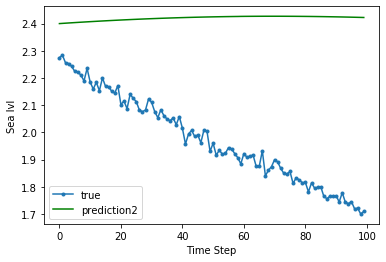

In [24]:
plt.plot(p.values[:100], marker='.', label="true")
#plt.plot(tide["h"]+numpy.mean(p.values), 'r', label="prediction")
plt.plot(t_tides_p[:100] + np.mean(p.values), 'g', label="prediction2")
plt.ylabel('Sea lvl')
plt.xlabel('Time Step')
plt.legend()
plt.show();




# UTIDE  

In [17]:
import utide
import matplotlib.dates as mdates
print(utide.__version__)

0.2.5


In [31]:
time = mdates.date2num(p.index.to_pydatetime())

coef = utide.solve(time, serie, lat=lat)

solve: matrix prep ... solution ... diagnostics ... done.


In [32]:
coef.keys()

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn'])

In [33]:
coef

{'name': array(['M2', 'K1', 'S2', 'O1', 'N2', 'SSA', 'P1', 'K2', 'SA', 'MU2', 'Q1',
        'NU2', '2N2', 'L2', 'J1', 'NO1', 'OO1', 'T2', 'MF', 'MM', 'PI1',
        'EPS2', 'H1', 'RHO1', 'ETA2', 'MSF', 'MSM', 'SIG1', 'M3', 'LDA2',
        'GAM2', 'PHI1', 'CHI1', 'SK3', 'THE1', 'MKS2', '2Q1', 'R2', 'M4',
        'MSN2', 'TAU1', 'OQ2', 'BET1', 'SO3', 'PSI1', '2MS6', 'SO1', 'S4',
        'MO3', 'H2', 'S1', 'MK3', '2MK5', 'SK4', 'UPS1', '2MK6', '2SK5',
        '2MN6', 'MSK6', 'MN4', 'M6', 'SN4', '3MK7', 'MS4', 'ALP1', 'M8',
        '2SM6', 'MK4'], dtype=object),
 'aux': {'frq': array([0.0805114 , 0.04178075, 0.08333333, 0.03873065, 0.07899925,
         0.00022816, 0.04155259, 0.08356149, 0.00011407, 0.07768947,
         0.0372185 , 0.07920162, 0.0774871 , 0.08202355, 0.0432929 ,
         0.04026859, 0.04483084, 0.08321926, 0.00305009, 0.00151215,
         0.04143851, 0.07617732, 0.08039733, 0.03742087, 0.08507364,
         0.00282193, 0.00130978, 0.03590872, 0.1207671 , 0.08182118,
       

In [34]:
ptime = mdates.date2num(p.index.to_pydatetime())
tide = utide.reconstruct(time, coef)

prep/calcs ... done.


In [35]:
tide.keys()

dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])

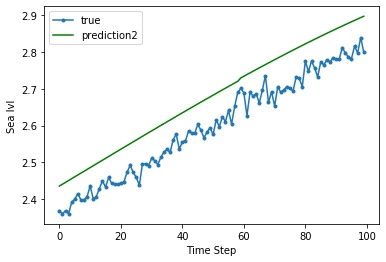

In [36]:
plt.plot(r.values[:100], marker='.', label="true")
#plt.plot(tide["h"]+numpy.mean(p.values), 'r', label="prediction")
plt.plot(tide["h"][:100] +np.mean(r.values), 'g', label="prediction2")
plt.ylabel('Sea lvl')
plt.xlabel('Time Step')
plt.legend()
plt.show();